<a href="https://colab.research.google.com/github/rpasquini/herramientas-econometricas-2022/blob/main/Experimentos_Aleatorizados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import statsmodels.api as sm  
from scipy import stats  
import numpy as np

Como ejemplo, vamos a analizar datos de una evaluación de impacto experimental (un Randomized Control Trial, RCT) llevada a cabo en Marruecos, donde se buscó estimar el impacto de la conexión a la red de agua.

Extracto de datos de: 

[Devoto, F., Duflo, E., Dupas, P., Parienté, W., & Pons, V. (2012). Happiness on tap: piped water adoption in urban Morocco. American Economic Journal: Economic Policy, 4(4), 68-99.](https://web.stanford.edu/~pdupas/MoroccoWaterConnections.pdf
)

Las variables fueron modificadas para el proposito de este ejercicio. 

**Descripción de variables**


motivacion: Dummy = 1 si el hogar recibió motivación para conexión \
conectado: Dummy = 1 si el hogar se conectó a la red de agua \
sexojefe: Dummy = 1 Masculino, 0 Femenino \
edadjefe: Edad Jefe de Hogar \
jefesabeleer: Dummy=1 Jefe sabe leer \
jefesabeescribir: Dummy=1 Jefe sabe escribir \
pdiasfueaescuela: Porcentaje dias hijos fueron a la escuela.




In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/rpasquini/econometrics_and_causality/master/happiness_on_tap_extract.csv')

In [3]:
df.head()

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
0,1,0,0,1,37.0,1.0,1.0,NaN
1,3,1,1,1,45.0,0.0,0.0,57.142860
2,5,0,0,1,50.0,1.0,1.0,85.714287
3,7,1,1,1,54.0,1.0,1.0,85.714287
4,8,0,0,2,66.0,0.0,0.0,NaN


In [ ]:
df.head()

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
0,1,0,0,1,37.0,1.0,1.0,NaN
1,3,1,1,1,45.0,0.0,0.0,57.142860
2,5,0,0,1,50.0,1.0,1.0,85.714287
3,7,1,1,1,54.0,1.0,1.0,85.714287
4,8,0,0,2,66.0,0.0,0.0,NaN


El experimento de Devoto et. al. asignó aleatoriamente una "motivación" a conectarse. Notando que la motivación fue efectiva para inducir la conexión, nos enfocaremos aquí en el intention-to-treat effect.

Nuestro propósito es estimar el efecto promedio de los que fueron motivados.  
Como hubo una asignación experimental, entonces sabemos que podemos recuperar el efecto causal comparando los sorteados para recibir la motivación contra los que no fueron elegidos. (Nota: Más adelante en el curso, cuando cubramos variables instrumentales, veremos que es posible recuperar el efecto de tratamiento propiamente dicho.)

Vamos a implementar la estimación de dos formas: 
1. Un test de diferencias de medias
2. La estimación de un modelo de regresión



Analicemos primero las diferencias entre motivados y no motivados:

In [9]:
df.groupby('motivacion').count()

,random_id,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
motivacion,,,,,,,
0,377,377,377,372,372,372,147
1,411,411,411,407,404,404,173


In [7]:
df['motivacion'].count()

788

In [10]:
df=df.dropna()

In [11]:
df.groupby('motivacion').mean()

,random_id,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
motivacion,,,,,,,
0,544.952055,0.150685,1.136986,47.349315,0.739726,0.726027,62.133074
1,522.321637,0.830409,1.099415,47.122807,0.701754,0.684211,57.811196


In [ ]:
dias_tratados=df.pdiasfueaescuela.loc[df.motivacion==1]
dias_control=df.pdiasfueaescuela.loc[df.motivacion==0]

In [14]:
dias_tratados=df.loc[df.motivacion==1].pdiasfueaescuela

In [15]:
dias_control=df.loc[df.motivacion==0].pdiasfueaescuela

In [16]:
dias_control

2      85.714287
7      71.428574
9      42.857143
20     42.857143
29     71.428574
         ...    
767    71.428574
768    14.285715
773    85.714287
776    42.857143
778    14.285715
Name: pdiasfueaescuela, Length: 146, dtype: float64

## Test de medias (supuesto varianzas son iguales)

Recordemos que la hipótesis nula del test de medias es la igualdad de las mismas. 


In [17]:
stats.ttest_ind(dias_tratados, dias_control, equal_var=True)

Ttest_indResult(statistic=-1.5002574789125818, pvalue=0.13454932763122404)

#Equivalencia del test a través de estimar OLS 



$pdiasescuela_i=\beta_0+\beta_1motivacion_i+\epsilon_i$

In [18]:
def ols(lista, data):
  """ 
  Funcion que realiza la regresion OLS
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.OLS(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [19]:
ols(['pdiasfueaescuela', 'motivacion'], df)

                            OLS Regression Results                            
Dep. Variable:       pdiasfueaescuela   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.251
Date:                Wed, 09 Nov 2022   Prob (F-statistic):              0.135
Time:                        15:54:33   Log-Likelihood:                -1476.3
No. Observations:                 317   AIC:                             2957.
Df Residuals:                     315   BIC:                             2964.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.1331      2.116     29.366      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Randomnization Inference Approach


In [22]:
lista=[["Buenos Aires",1,1],["Catamarca",1,1],["Chaco",1,1],["Chubut",1,1],["Córdoba",1,0],["Corrientes",0,0],["Entre Ríos",0,0],["Formosa",0,0],["Jujuy",0,0],["La Pampa",0,0]]
variables=['provincia',"T","Y"]
df=pd.DataFrame(lista, columns=variables)

In [23]:
df

,provincia,T,Y
0,Buenos Aires,1,1
1,Catamarca,1,1
2,Chaco,1,1
3,Chubut,1,1
4,Córdoba,1,0
5,Corrientes,0,0
6,Entre Ríos,0,0
7,Formosa,0,0
8,Jujuy,0,0
9,La Pampa,0,0


In [27]:
df.loc[df['T']==1]['Y'].mean()

0.8

In [28]:
df.loc[df['T']==0]['Y'].mean()

0.0

In [29]:
df.loc[df['T']==1]['Y'].mean()-df.loc[df['T']==0]['Y'].mean()

0.8

In [ ]:
  Y_tratadas=df['Y'].loc[df['T']==1]
  Y_control=df['Y'].loc[df['T']==0]
  dif_means=np.mean(Y_tratadas)-np.mean(Y_control) #computamos la diferencia de medias
  dif_means

0.8

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81ea032198>]],
      dtype=object)

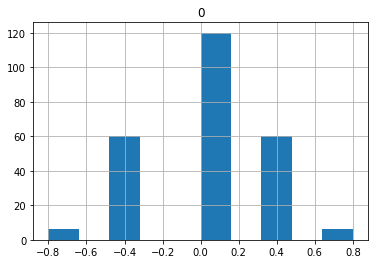

In [ ]:
from itertools import permutations 

import numpy as np

iteradorcomb=combinations(df.index,5)  #Generamos un iterador de permutaciones. Cada vez que invoquemos la funcion next() sobre él me devolverá una iteracion.
listadediferencias=[]

for i in range(0,252):
  posicionestratadosfalso=next(iteradorcomb)
  df.loc[df.index.isin(posicionestratadosfalso),'falsotratamiento']=1
  df.loc[~df.index.isin(posicionestratadosfalso),'falsotratamiento']=0
  Y_tratadas=df['Y'].loc[df['falsotratamiento']==1]
  Y_control=df['Y'].loc[df['falsotratamiento']==0]
  dif_means=np.mean(Y_tratadas)-np.mean(Y_control) #computamos la diferencia de medias
  listadediferencias.append(dif_means)

pd.DataFrame(listadediferencias).hist()

In [ ]:
stats.percentileofscore(listadediferencias,0.8)

99.0079365079365